# Correlating well log pairs: Complex Dynamic Time Warping with boundary constraints

## Introduction to dynamic time warping

In [1]:
# Data manipulation and analysis
import os
import gc
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from pyCoreRelator import (
    load_log_data,
    load_core_age_constraints,
    load_pickeddepth_ages_from_csv,
    run_multi_parameter_analysis,
    calculate_quality_comparison_t_statistics,
    plot_quality_comparison_t_statistics
)

<hr>

### Define basic parameters

### Define core pairs

In [2]:
# Define core names as variables for easy reference
# CORE_A = "M9907-22PC"
CORE_A = "M9907-25PC"
# CORE_A = "M9907-23PC"
# CORE_A = "M9907-12PC"
# CORE_A = "M9907-31PC"
# CORE_A = "M9907-11PC"
# CORE_A = "RR0207-56PC" 
# CORE_A = "M9907-08PC"

# CORE_B = "M9907-11PC"
# CORE_B = "M9907-09PC"
CORE_B = "M9907-23PC"
# CORE_B = "M9907-30PC"
# CORE_B = "RR0207-56PC" 
# CORE_B = "RR0207-55KC"

#### Log data paths and column name structure

In [3]:
# Define log columns to extract
LOG_COLUMNS = ['hiresMS', 'CT', 'Lumin']  # Choose which logs to include
# LOG_COLUMNS = ['hiresMS']  # Choose which logs to include
# LOG_COLUMNS = ['CT']  # Choose which logs to include
# LOG_COLUMNS = ['Lumin']  # Choose which logs to include

# Define depth column
DEPTH_COLUMN = 'SB_DEPTH_cm'

# For multidimensional DTW, choose DTW method:
pca_for_dependent_dtw=False

# Define directory paths
mother_dir = '/Users/larryslai/Library/CloudStorage/Dropbox/My Documents/University of Texas Austin/(Project) NWP turbidites/Cascadia_core_data/OSU_dataset/'

# Define paths for Core A
core_a_log_paths = {
    'hiresMS': f'{mother_dir}_compiled_logs/{CORE_A}/ML_filled/{CORE_A}_hiresMS_MLfilled.csv',
    'CT': f'{mother_dir}_compiled_logs/{CORE_A}/ML_filled/{CORE_A}_CT_MLfilled.csv',
    'Lumin': f'{mother_dir}_compiled_logs/{CORE_A}/ML_filled/{CORE_A}_RGB_MLfilled.csv',
    'R': f'{mother_dir}_compiled_logs/{CORE_A}/ML_filled/{CORE_A}_RGB_MLfilled.csv',
    'G': f'{mother_dir}_compiled_logs/{CORE_A}/ML_filled/{CORE_A}_RGB_MLfilled.csv',
    'B': f'{mother_dir}_compiled_logs/{CORE_A}/ML_filled/{CORE_A}_RGB_MLfilled.csv',
    'Den_gm/cc': f'{mother_dir}_compiled_logs/{CORE_A}/ML_filled/{CORE_A}_MST_MLfilled.csv'
}

# Define paths for Core B
core_b_log_paths = {
    'hiresMS': f'{mother_dir}_compiled_logs/{CORE_B}/ML_filled/{CORE_B}_hiresMS_MLfilled.csv',
    'CT': f'{mother_dir}_compiled_logs/{CORE_B}/ML_filled/{CORE_B}_CT_MLfilled.csv',
    'Lumin': f'{mother_dir}_compiled_logs/{CORE_B}/ML_filled/{CORE_B}_RGB_MLfilled.csv',
    'R': f'{mother_dir}_compiled_logs/{CORE_B}/ML_filled/{CORE_B}_RGB_MLfilled.csv',
    'G': f'{mother_dir}_compiled_logs/{CORE_B}/ML_filled/{CORE_B}_RGB_MLfilled.csv',
    'B': f'{mother_dir}_compiled_logs/{CORE_B}/ML_filled/{CORE_B}_RGB_MLfilled.csv',
    'Den_gm/cc': f'{mother_dir}_compiled_logs/{CORE_B}/ML_filled/{CORE_B}_MST_MLfilled.csv'
}

# Define column mapping for alternative column names
column_alternatives = {
    'hiresMS': ['MS'],
    'CT': ['CT_value'],
    'R': ['R', 'red', 'Red'],
    'G': ['G', 'green', 'Green'],
    'B': ['B', 'blue', 'Blue'],
    'Lumin': ['luminance', 'Luminance'],
    'Den_gm/cc': ['Density', 'density']
}

<hr>

### Load log data

In [4]:
# Load data for Core A
log_a, md_a, _, _, _ = load_log_data(
    core_a_log_paths,
    log_columns=LOG_COLUMNS,
    depth_column=DEPTH_COLUMN,
    normalize=True,
    column_alternatives=column_alternatives
)

# Load data for Core B
log_b, md_b, _, _, _ = load_log_data(
    core_b_log_paths,
    log_columns=LOG_COLUMNS,
    depth_column=DEPTH_COLUMN,
    normalize=True,
    column_alternatives=column_alternatives
)

### Load picked depth boundaries

In [5]:
%matplotlib inline

# Define paths to the CSV files
pickeddepth_a_csv = f'pickeddepth/{CORE_A}_pickeddepth.csv'
pickeddepth_b_csv = f'pickeddepth/{CORE_B}_pickeddepth.csv'

# Load picked depths and extract category 1 depths
if os.path.exists(pickeddepth_a_csv):
    picked_data_a = pd.read_csv(pickeddepth_a_csv)
    all_depths_a_cat1 = picked_data_a[picked_data_a['category'] == 1]['picked_depths_cm'].values.astype('float32')
    intepreted_bed_a_cat1 = picked_data_a[picked_data_a['category'] == 1]['interpreted_bed'].fillna('').values.astype('str')
else:
    print(f"Warning: {pickeddepth_a_csv} not found. Using empty array for all_depths_a_cat1.")
    all_depths_a_cat1 = np.array([]).astype('float32')
    intepreted_bed_a_cat1 = np.array([]).astype('str').fillna('')

if os.path.exists(pickeddepth_b_csv):
    picked_data_b = pd.read_csv(pickeddepth_b_csv)
    all_depths_b_cat1 = picked_data_b[picked_data_b['category'] == 1]['picked_depths_cm'].values.astype('float32')
    intepreted_bed_b_cat1 = picked_data_b[picked_data_b['category'] == 1]['interpreted_bed'].fillna('').values.astype('str')
else:
    print(f"Warning: {pickeddepth_b_csv} not found. Using empty array for all_depths_b_cat1.")
    all_depths_b_cat1 = np.array([]).astype('float32')
    intepreted_bed_b_cat1 = np.array([]).astype('str').fillna('')

### Load age data

In [6]:
# Load age constraints for both cores
consider_adjacent_core = True

data_columns = {
    'age': 'calib810_agebp',
    'pos_error': 'calib810_2sigma_pos', 
    'neg_error': 'calib810_2sigma_neg',
    'min_depth': 'mindepth_cm',
    'max_depth': 'maxdepth_cm',
    'in_sequence': 'in_sequence',
    'core': 'core',
    'interpreted_bed': 'interpreted_bed'
}

# Configuration: Define the path to the age constraints csv file
age_base_path = '/Users/larryslai/Library/CloudStorage/Dropbox/My Documents/University of Texas Austin/(Project) NWP turbidites/Cascadia_core_data/Age constraints/Goldfinger2012'

# Load age constraints for both cores: Load the age constraints for both cores from the csv file
age_data_a = load_core_age_constraints(CORE_A, age_base_path, consider_adjacent_core, data_columns, mute_mode=True)
age_data_b = load_core_age_constraints(CORE_B, age_base_path, consider_adjacent_core, data_columns, mute_mode=True)

### Load estimated ages for each picked depth boundary from csv

In [7]:
# Load estimated boundary age data for both cores from CSV files using the imported function
cores = [CORE_A, CORE_B]
pickeddepth_ages = {}

# Define the uncertainty method: 'MonteCarlo', 'Linear', or 'Gaussian'
uncertainty_method='MonteCarlo'   

for core in cores:
    core_age_csv = f"pickeddepth_ages/{core}_pickeddepth_ages_{uncertainty_method}.csv"
    pickeddepth_ages[core] = load_pickeddepth_ages_from_csv(core_age_csv)

# Assign to individual variables for backward compatibility
if CORE_A in pickeddepth_ages:
    pickeddepth_ages_a = pickeddepth_ages[CORE_A]
if CORE_B in pickeddepth_ages:
    pickeddepth_ages_b = pickeddepth_ages[CORE_B]

Loaded 20 pickeddepth ages from M9907-25PC_pickeddepth_ages_MonteCarlo.csv
Loaded 21 pickeddepth ages from M9907-23PC_pickeddepth_ages_MonteCarlo.csv


<hr>

## Compute quality metric distribution for all stituation

In [8]:
# # Cell: Multi-Parameter Distribution Analysis

# test_age_constraint_removal = True  # Set to False to disable age constraint removal testing

# # For multidimensional DTW, choose DTW method:
# pca_for_dependent_dtw=False

# # Run all parameter combinations and plot distribution curves together

# # Define all parameter combinations to test
# parameter_combinations = [
#     # {'age_consideration': True, 'restricted_age_correlation': True, 'shortest_path_search': False},
#     {'age_consideration': True, 'restricted_age_correlation': True, 'shortest_path_search': True},
#     # {'age_consideration': True, 'restricted_age_correlation': False, 'shortest_path_search': False},
#     # {'age_consideration': True, 'restricted_age_correlation': False, 'shortest_path_search': True},
#     # {'age_consideration': False, 'restricted_age_correlation': False, 'shortest_path_search': False},
#     {'age_consideration': False, 'restricted_age_correlation': False, 'shortest_path_search': True}
# ]

# # Define all quality indices to process
# target_quality_indices = ['corr_coef', 'norm_dtw']

# output_csv_filenames = {}
# for quality_index in target_quality_indices:
#     output_csv_filenames[quality_index] = f'outputs/{CORE_A}_{CORE_B}/{"_".join(LOG_COLUMNS)}/{quality_index}_fit_params.csv'

# # Define synthetic CSV filenames for consistent bin sizing
# synthetic_csv_filenames = {}
# for quality_index in target_quality_indices:
#     synthetic_csv_filenames[quality_index] = f'outputs/synthetic_PDFs_{"_".join(LOG_COLUMNS)}_{quality_index}.csv'

# # Execute the analysis function
# run_multi_parameter_analysis(
#     # Core data inputs
#     log_a=log_a, 
#     log_b=log_b, 
#     md_a=md_a, 
#     md_b=md_b,
#     all_depths_a_cat1=all_depths_a_cat1,
#     all_depths_b_cat1=all_depths_b_cat1,
#     pickeddepth_ages_a=pickeddepth_ages_a,
#     pickeddepth_ages_b=pickeddepth_ages_b,
#     age_data_a=age_data_a,
#     age_data_b=age_data_b,
#     uncertainty_method=uncertainty_method,
    
#     # Analysis parameters
#     parameter_combinations=parameter_combinations,
#     target_quality_indices=target_quality_indices,
#     test_age_constraint_removal=test_age_constraint_removal,
    
#     # Core identifiers
#     core_a_name=CORE_A,
#     core_b_name=CORE_B,
    
#     # Output configuration
#     output_csv_filenames=output_csv_filenames,
    
#     # Optional parameter
#     pca_for_dependent_dtw=pca_for_dependent_dtw,

#     # Maximum number of scenarios per constraint removal layer
#     max_search_per_layer= 50,

#     # Number of cores used in parallel processing
#     n_jobs=-1     # -1: uses all available cores
# )

### Plotting: compare the quality metric to the null hypothesis

  Calculating statistics for norm_dtw: 100%|██████████| 16/16 [00:00<00:00, 346.71it/s]


✓ Distribution plot saved as: outputs/M9907-25PC_M9907-23PC/hiresMS_CT_Lumin/corr_coef_compare2null.svg
⚠️  WARNING: No valid correlatable datums to be marked.
✓ t-statistics plot saved as: outputs/M9907-25PC_M9907-23PC/hiresMS_CT_Lumin/corr_coef_compare2null_tstat.svg
✓ Distribution plot saved as: outputs/M9907-25PC_M9907-23PC/hiresMS_CT_Lumin/norm_dtw_compare2null.svg
⚠️  WARNING: No valid correlatable datums to be marked.
✓ t-statistics plot saved as: outputs/M9907-25PC_M9907-23PC/hiresMS_CT_Lumin/norm_dtw_compare2null_tstat.svg


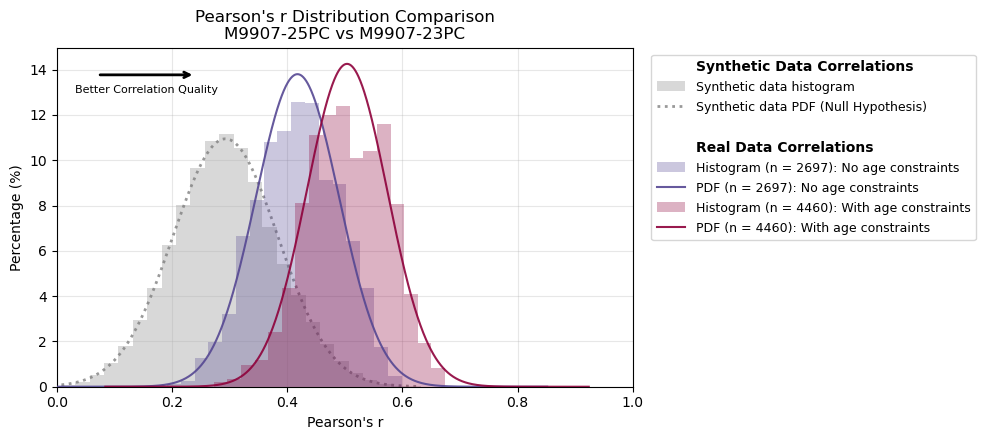

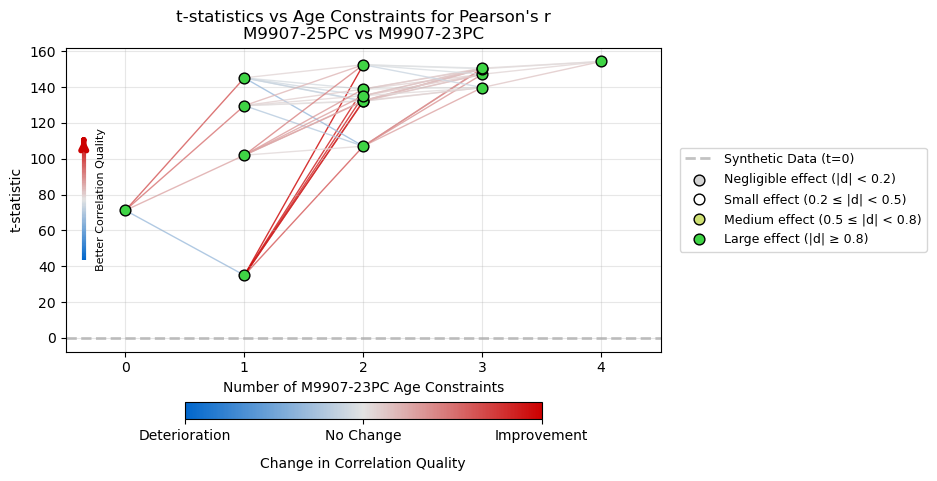

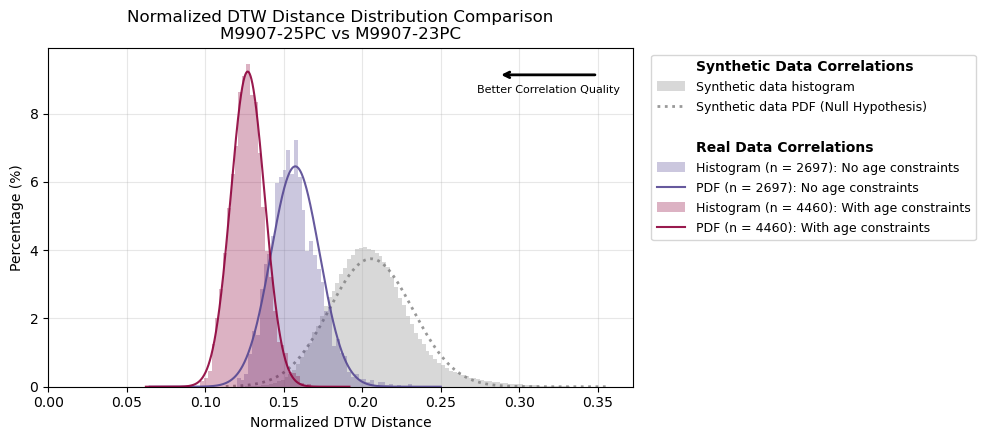

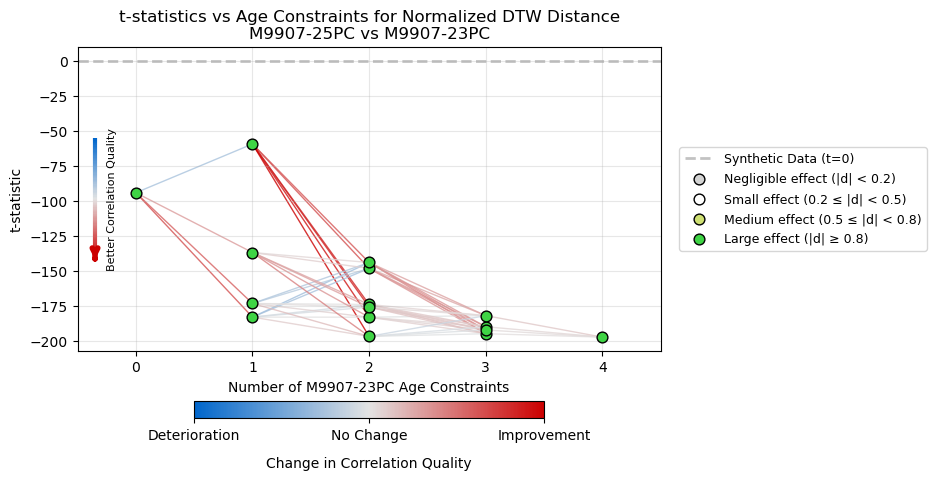

In [9]:
# Define file names outside the function
target_quality_indices = ['corr_coef', 'norm_dtw']

# Define input path for master CSV filenames
master_csv_filenames = {}
for quality_index in target_quality_indices:
    master_csv_filenames[quality_index] = f'outputs/{CORE_A}_{CORE_B}/{"_".join(LOG_COLUMNS)}/{quality_index}_fit_params.csv'

# Define input path for synthetic CSV filenames
synthetic_csv_filenames = {}
for quality_index in target_quality_indices:
    synthetic_csv_filenames[quality_index] = f'outputs/synthetic_PDFs_{"_".join(LOG_COLUMNS)}_{quality_index}.csv'

# Define output figure filenames
output_figure_filenames = {}
for quality_index in target_quality_indices:
    # output_figure_filenames[quality_index] = f'outputs/{CORE_A}_{CORE_B}/{"_".join(LOG_COLUMNS)}/{quality_index}_compare2null.png'
    output_figure_filenames[quality_index] = f'outputs/{CORE_A}_{CORE_B}/{"_".join(LOG_COLUMNS)}/{quality_index}_compare2null.svg'


# Define animated gifs showing progressive constraint addition
output_gif_filenames = {}
for quality_index in target_quality_indices:
    output_gif_filenames[quality_index] = f'outputs/{CORE_A}_{CORE_B}/{"_".join(LOG_COLUMNS)}/{quality_index}_compare2null.gif'

# Define mapping CSV filename: Try restricted_age_optimal first, fallback to no_age_optimal if it doesn't exist
sequential_mappings_csv = f'outputs/{CORE_A}_{CORE_B}/{"_".join(LOG_COLUMNS)}/mappings_restricted_age_optimal.csv'
if not os.path.exists(sequential_mappings_csv):
    sequential_mappings_csv = f'outputs/{CORE_A}_{CORE_B}/{"_".join(LOG_COLUMNS)}/mappings_no_age_optimal.csv'
    if not os.path.exists(sequential_mappings_csv):
        sequential_mappings_csv = None
        
# Step 1: Calculate statistics (run once)
calculate_quality_comparison_t_statistics(
    target_quality_indices=target_quality_indices,
    master_csv_filenames=master_csv_filenames,
    synthetic_csv_filenames=synthetic_csv_filenames,
    CORE_A=CORE_A,
    CORE_B=CORE_B,
    mute_mode=False
)

# Step 2: Plot results
plot_quality_comparison_t_statistics(
    target_quality_indices=target_quality_indices,
    master_csv_filenames=master_csv_filenames,
    synthetic_csv_filenames=synthetic_csv_filenames,
    CORE_A=CORE_A,
    CORE_B=CORE_B,
    mute_mode=True,
    save_fig=True,
    output_figure_filenames=output_figure_filenames,
    save_gif=False, 
    output_gif_filenames=output_gif_filenames,
    max_frames=40,
    plot_real_data_histogram=True,
    plot_age_removal_step_pdf=False,
    show_best_datum_match=True,
    sequential_mappings_csv=sequential_mappings_csv
)

# plot_quality_comparison_t_statistics(
#     target_quality_indices=target_quality_indices,
#     master_csv_filenames=master_csv_filenames,
#     synthetic_csv_filenames=synthetic_csv_filenames,
#     CORE_A=CORE_A,
#     CORE_B=CORE_B,
#     mute_mode=True,
#     save_fig=False,
#     output_figure_filenames=output_figure_filenames,
#     save_gif=True, 
#     output_gif_filenames=output_gif_filenames,
#     max_frames=40,
#     plot_real_data_histogram=False,
#     plot_age_removal_step_pdf=True,
#     show_best_datum_match=True,
#     sequential_mappings_csv=sequential_mappings_csv
# )